In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the LDA and CTM results
lda_results_df = pd.read_pickle('../saved_models/lda_model_results_summary.pkl')
ctm_results_df = pd.read_pickle('../saved_models/ctm_model_results_summary.pkl')

In [2]:
# Remove all rows with 5 topics from the LDA DataFrame
lda_results_df = lda_results_df[lda_results_df['num_topics'] != 5]

# Extract data for LDA
lda_num_topics = lda_results_df['num_topics']
lda_coherence_scores = lda_results_df['coherence_score']
lda_topic_diversity = lda_results_df.get('topic_diversity', None)

# Extract data for CTM
ctm_num_topics = ctm_results_df['num_topics']
ctm_coherence_scores = ctm_results_df['coherence_score']
ctm_topic_diversity = ctm_results_df.get('topic_diversity', None)

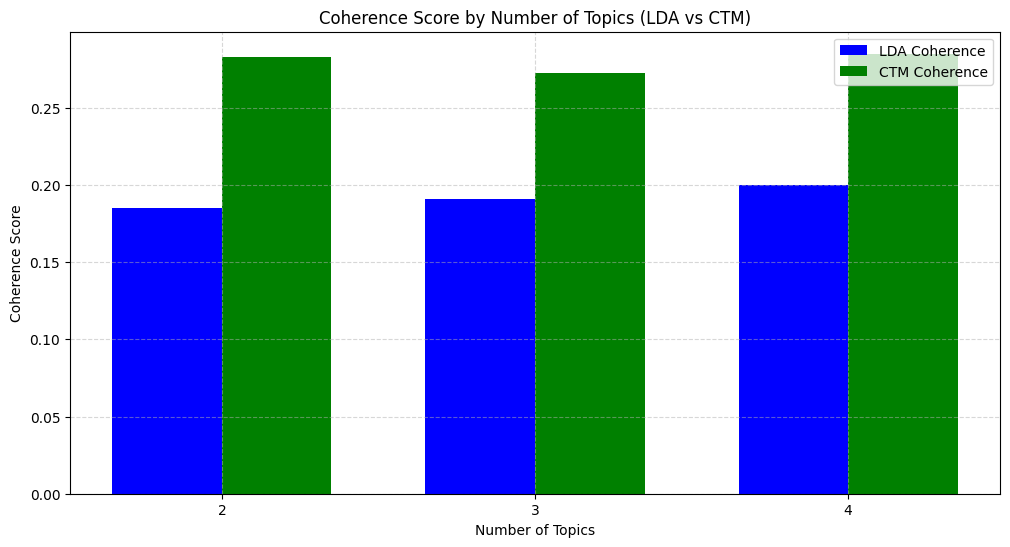

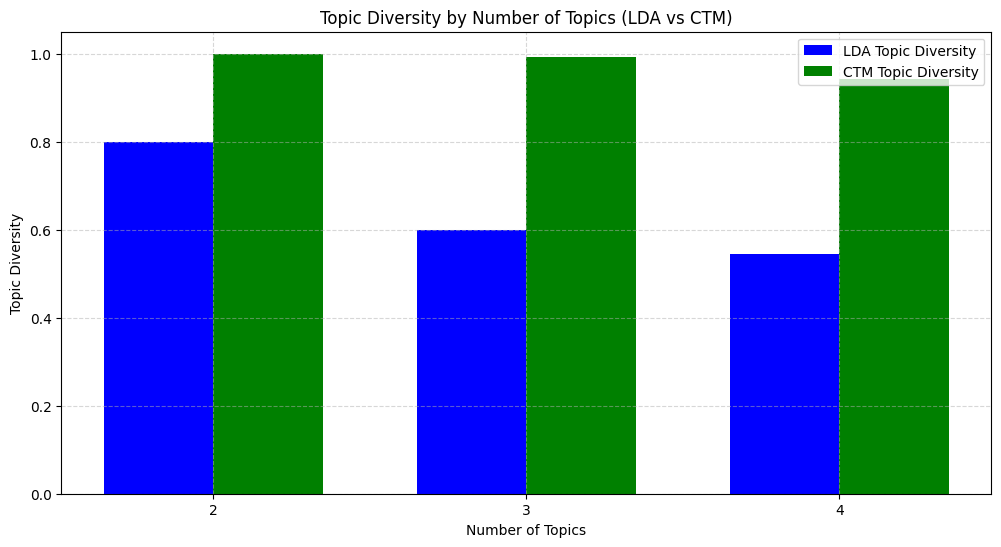

In [3]:
# Coherence Score Bar Plot
# Prepare the data for plotting coherence scores
unique_topics_lda = lda_results_df['num_topics'].unique()
unique_topics_ctm = ctm_results_df['num_topics'].unique()
unique_topics = sorted(set(unique_topics_lda) | set(unique_topics_ctm))  # Sorted unique topics

lda_coherence_means = [
    lda_results_df[lda_results_df['num_topics'] == num]['coherence_score'].mean() if num in unique_topics_lda else np.nan
    for num in unique_topics
]
ctm_coherence_means = [
    ctm_results_df[ctm_results_df['num_topics'] == num]['coherence_score'].mean() if num in unique_topics_ctm else np.nan
    for num in unique_topics
]

x = np.arange(len(unique_topics))  # the label locations
width = 0.35  # the width of the bars

# Plot Coherence Score
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, lda_coherence_means, width, label='LDA Coherence', color='b')
bars2 = ax.bar(x + width/2, ctm_coherence_means, width, label='CTM Coherence', color='g')

# Add labels, title, and legend
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Score by Number of Topics (LDA vs CTM)')
ax.set_xticks(x)
ax.set_xticklabels(unique_topics)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Topic Diversity Bar Plot (if available for both LDA and CTM)
if lda_topic_diversity is not None and ctm_topic_diversity is not None:
    lda_diversity_means = [
        lda_results_df[lda_results_df['num_topics'] == num]['topic_diversity'].mean() if num in unique_topics_lda else np.nan
        for num in unique_topics
    ]
    ctm_diversity_means = [
        ctm_results_df[ctm_results_df['num_topics'] == num]['topic_diversity'].mean() if num in unique_topics_ctm else np.nan
        for num in unique_topics
    ]

    # Plot Topic Diversity
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, lda_diversity_means, width, label='LDA Topic Diversity', color='b')
    bars2 = ax.bar(x + width/2, ctm_diversity_means, width, label='CTM Topic Diversity', color='g')

    # Add labels, title, and legend
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Topic Diversity')
    ax.set_title('Topic Diversity by Number of Topics (LDA vs CTM)')
    ax.set_xticks(x)
    ax.set_xticklabels(unique_topics)
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [4]:
lda_results_df_sorted = lda_results_df.sort_values(by='coherence_score', ascending=False)
ctm_results_df_sorted = ctm_results_df.sort_values(by='coherence_score', ascending=False)
best_lda_params = lda_results_df_sorted.iloc[0]
best_ctm_params = ctm_results_df_sorted.iloc[0]
print("Best LDA Model Parameters:")
print(best_lda_params)

print("\nBest CTM Model Parameters:")
print(best_ctm_params)

Best LDA Model Parameters:
model_id                103
num_topics                4
alpha                  auto
beta                    0.1
passes                   20
iterations              100
coherence_score    0.205612
topic_diversity        0.55
Name: 28, dtype: object

Best CTM Model Parameters:
model_id           15.000000
num_topics          2.000000
epochs             20.000000
learning_rate       0.005000
batch_size         64.000000
coherence_score     0.344318
topic_diversity     1.000000
Name: 2, dtype: float64


In [5]:
from gensim.models import LdaModel
from contextualized_topic_models.models.ctm import CombinedTM
import importlib
from PopMusicInformationRetrieval import utility_functions as utils
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from gensim import corpora
importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/Topic Modeling/utility_functions.py'>

In [8]:
# Load your dataframe
df = pd.read_pickle('../Data/dataframes/preprocessed_df.pkl')

if isinstance(df['Tokens'].iloc[0], str):
    import ast
    df['Tokens'] = df['Tokens'].apply(ast.literal_eval)

texts = df['Tokens']
texts_bow = [' '.join(tokens) for tokens in df['Tokens']]
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]
df['Lyrics'] = df['Lyrics'].apply(utils.light_preprocessing)
documents = df['Lyrics']

In [9]:
tp = TopicModelDataPreparation("all-mpnet-base-v2", max_seq_length=512)
training_dataset = tp.fit(text_for_contextual=documents, text_for_bow=texts_bow)

/Users/borosabel/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 1919 words, the model instead truncates to 512 tokens.
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
dictionary = corpora.Dictionary(texts)

In [11]:
# Retrain the best LDA model
best_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=int(best_lda_params['num_topics']),
    alpha=best_lda_params['alpha'],
    eta=float(best_lda_params['beta']),
    passes=int(best_lda_params['passes']),
    iterations=int(best_lda_params['iterations']),
    random_state=42
)

best_ctm_model = CombinedTM(
    bow_size=len(tp.vocab),
    contextual_size=768,
    n_components=int(best_ctm_params['num_topics']),
    num_epochs=int(best_ctm_params['epochs']),
    batch_size=int(best_ctm_params['batch_size']),
    activation='softplus',
    dropout=0.2,
    solver='adam',
    num_data_loader_workers=0,
)

# Train the model with the training dataset
best_ctm_model.fit(training_dataset)

Epoch: [20/20]	 Seen Samples: [26880/27360]	Train Loss: 1200.4737606956846	Time: 0:00:00.176673: : 20it [00:03,  5.25it/s]
100%|██████████| 22/22 [00:00<00:00, 186.98it/s]


In [12]:
# Extract topics from LDA
lda_topics = best_lda_model.show_topics(num_topics=int(best_lda_params['num_topics']), num_words=10, formatted=False)

# Extract topics from CTM
ctm_topics = best_ctm_model.get_topic_lists(10)

In [13]:
# Create DataFrame for LDA topics
lda_topic_df = pd.DataFrame({
    f'Topic {i+1}': [word for word, _ in topic_words]
    for i, (_, topic_words) in enumerate(lda_topics)
}).transpose()

# Create DataFrame for CTM topics (CTM topics is already in a list of lists format)
ctm_topic_df = pd.DataFrame({
    f'Topic {i+1}': topic
    for i, topic in enumerate(ctm_topics)
}).transpose()

# Display the DataFrames for verification
print("LDA Topics DataFrame:")
print(lda_topic_df)

print("\nCTM Topics DataFrame:")
print(ctm_topic_df)

LDA Topics DataFrame:
             0      1      2             3     4     5     6     7     8  \
Topic 1     go   know  rhyme          make  come   let   say   man  back   
Topic 2  nigga   fuck   shit  motherfucker   ass    go  know  come  back   
Topic 3  nigga  bitch   know          fuck  want  shit  make    go   see   
Topic 4    one   know     go          time   man  love  come   see  live   

             9  
Topic 1   want  
Topic 2  bitch  
Topic 3   back  
Topic 4  would  

CTM Topics DataFrame:
               0      1             2       3       4     5       6      7  \
Topic 1  nothing  verse      attitude  course  bounce   fix  pretty  tapes   
Topic 2     fuck  nigga  motherfucker   young    bust  work    shit  close   

                 8       9  
Topic 1  situation    hook  
Topic 2        rip  always  


In [17]:
# Define topic labels based on your model's interpretation
topic_labels = {
    0: "Artistic/Rhythmic",
    1: "Street Life/Aggressive"
}

# Get the topic distribution for each document
topic_distributions = best_ctm_model.get_doc_topic_distribution(training_dataset, n_samples=20)

# Extract the dominant topic for each song (highest probability)
df['Dominant_Topic'] = [int(np.argmax(dist)) for dist in topic_distributions]

100%|██████████| 22/22 [00:00<00:00, 118.08it/s]


In [18]:
# Assign descriptive labels to the dominant topic for each song
df['Dominant_Topic_Label'] = df['Dominant_Topic'].map(topic_labels)

# Example coast information: Assuming you have a 'Coast' column with 'East' or 'West' as values.
# If you don't have this column, create it based on your dataset criteria.
# df['Coast'] = ['East' if <condition> else 'West' for <each row in your data>]

# Ensure 'Coast' and 'Dominant_Topic_Label' columns exist in the dataframe
print(df[['Lyrics', 'Dominant_Topic', 'Dominant_Topic_Label', 'Coast']].head())

                                              Lyrics  Dominant_Topic  \
0  yo my crew is in the house terra herb mcgruff ...               1   
1  it's the number one crew in the area big l be ...               1   
2  there are too many mc's who are overrated you ...               0   
3  let me get to the point real quick when ya poc...               1   
4  a yo spark up the phillies and pass the stout ...               0   

     Dominant_Topic_Label       Coast  
0  Street Life/Aggressive  east_coast  
1  Street Life/Aggressive  east_coast  
2       Artistic/Rhythmic  east_coast  
3  Street Life/Aggressive  east_coast  
4       Artistic/Rhythmic  east_coast  


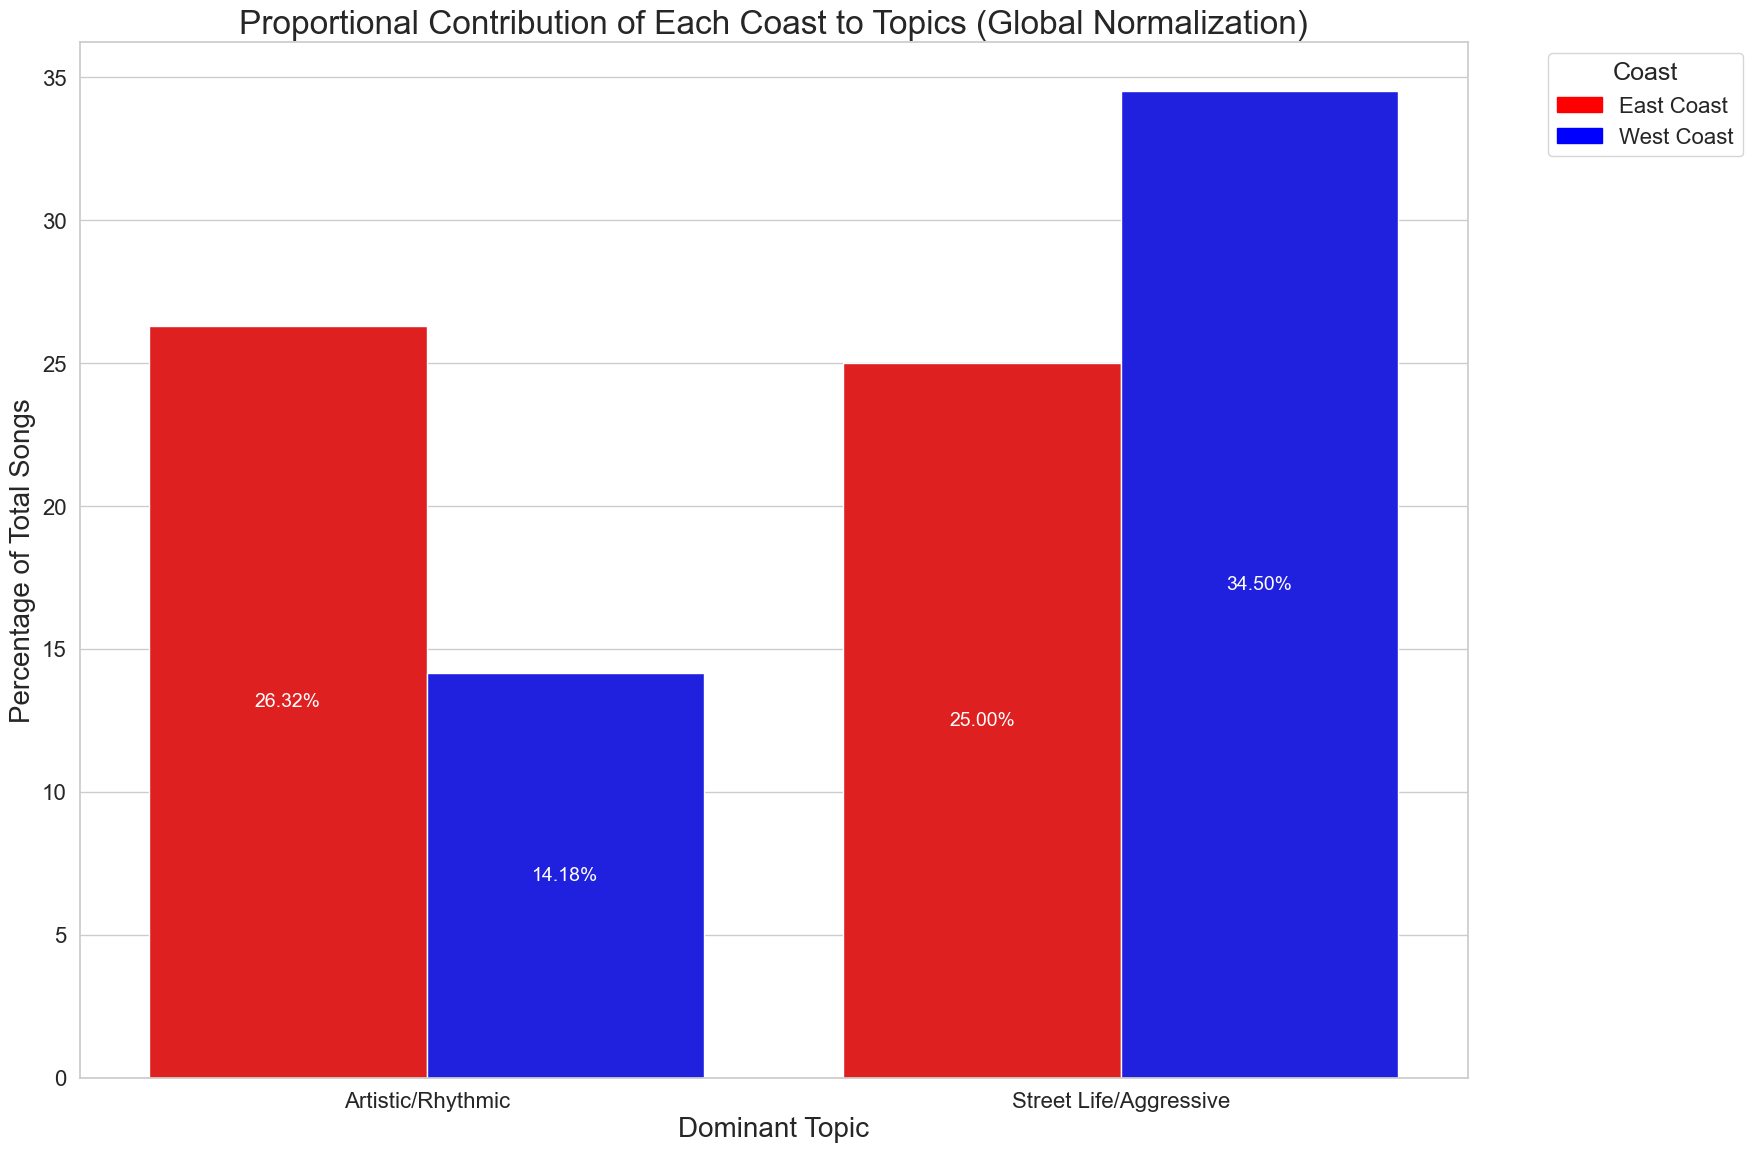

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Assuming df has 'Coast' and 'Dominant_Topic_Label' columns
# Group by Coast and Dominant_Topic_Label, then count occurrences
topic_counts = df.groupby(['Coast', 'Dominant_Topic_Label']).size().unstack(fill_value=0)

# Calculate the global percentage (not coast-specific) so that total sums to 100%
total_songs = topic_counts.values.sum()  # Total number of songs across both coasts
topic_counts_percentage = (topic_counts / total_songs) * 100  # Normalize by global total

# Convert to a long-form DataFrame for seaborn plotting
topic_counts_percentage_long = topic_counts_percentage.reset_index().melt(id_vars="Coast", var_name="Topic", value_name="Percentage")

# Set the seaborn style
sns.set(style="whitegrid")

# Create a larger figure explicitly with seaborn
plt.figure(figsize=(18, 12))

# Plot using seaborn with specified colors to ensure they show up in the legend
ax = sns.barplot(data=topic_counts_percentage_long, x="Topic", y="Percentage", hue="Coast", palette=['red', 'blue'])

# Add percentage labels in the middle of each bar, hiding zero values
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add the label if height is greater than 0
        ax.text(x=p.get_x() + p.get_width() / 2,
                y=height / 2,
                s=f'{height:.2f}%',
                ha='center', va='center',
                fontsize=14, color='white' if height > 10 else 'black')

# Customize the plot
plt.title("Proportional Contribution of Each Coast to Topics (Global Normalization)", fontsize=24)
plt.xlabel("Dominant Topic", fontsize=20)
plt.ylabel("Percentage of Total Songs", fontsize=20)

# Create a custom legend to ensure colors appear
legend_labels = [Patch(color='red', label='East Coast'), Patch(color='blue', label='West Coast')]
plt.legend(handles=legend_labels, title="Coast", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=16, title_fontsize=18)

# Adjust tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure before showing it
plt.tight_layout(pad=2)
plt.savefig("coast_topic_contribution.png", dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

In [32]:
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Tokens,Processed_Lyrics,Dominant_Topic,Dominant_Topic_Label
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yo my crew is in the house terra herb mcgruff ...,"[crew, house, bless, big, mike, imma, set, fol...",crew house terra herb mcgruff buddah bless big...,1,Street Life/Aggressive
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it's the number one crew in the area big l be ...,"[number, one, crew, big, nigga, men, win, kill...",number one crew area big lightin nigga incense...,1,Street Life/Aggressive
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there are too many mc's who are overrated you ...,"[many, mcs, ask, even, supposed, make, rap, kn...",many mcs overrated ask even supposed make rap ...,0,Artistic/Rhythmic
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let me get to the point real quick when ya poc...,"[let, point, real, quick, pocket, thick, mad, ...",let get point real quick pocket thick mad chic...,1,Street Life/Aggressive
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yo spark up the phillies and pass the stout ...,"[pass, make, quick, money, grip, ass, street, ...",spark phillies pass stout make quick money gri...,0,Artistic/Rhythmic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,i'ma say this and i'ma end mine if you ain't d...,"[say, end, mine, point, one, south, shit, need...",say end mine africans united states period poi...,1,Street Life/Aggressive
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,bitches ain't shit but hoes and tricks bitches...,"[bitch, shit, hoe, trick, bitch, shit, hoe, tr...",bitch shit hoe trick bitch shit hoe trick lick...,1,Street Life/Aggressive
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"yes it is i "" says me and all who agree are mo...","[yes, say, three, yes, house, sure, want, talk...",yes say agree three yes house sure want talk h...,1,Street Life/Aggressive
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,one two three and to the four snoop doggy dogg...,"[one, two, three, four, dog, dr, dre, door, re...",one two three four snoop doggy dog dr dre door...,1,Street Life/Aggressive


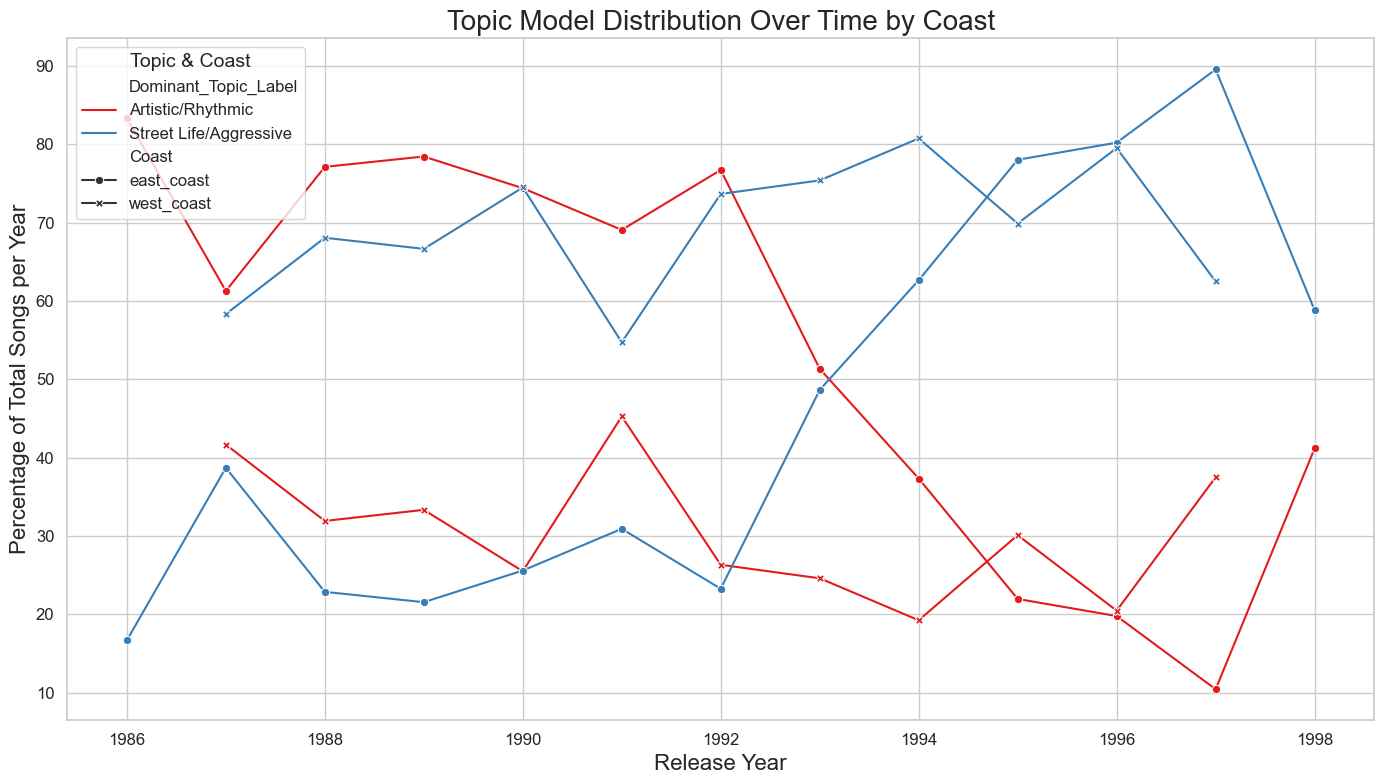

In [37]:

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df has 'Release Year', 'Coast', and 'Dominant_Topic_Label' columns
# Group by Release Year, Coast, and Dominant Topic Label, and count occurrences
topic_trends = df.groupby(['Release Year', 'Coast', 'Dominant_Topic_Label']).size().reset_index(name='Count')

# Calculate the percentage of each topic within each year and coast
# Using transform to broadcast the sum within each group back to the original group size
topic_trends['Percentage'] = (topic_trends['Count'] /
                              topic_trends.groupby(['Release Year', 'Coast'])['Count'].transform('sum')) * 100

# Set seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(14, 8))

# Plot using seaborn lineplot to show the trend of each topic over time, by coast
ax = sns.lineplot(data=topic_trends, x='Release Year', y='Percentage', hue='Dominant_Topic_Label',
                  style='Coast', markers=True, dashes=False, palette='Set1')

# Customize the plot
plt.title("Topic Model Distribution Over Time by Coast", fontsize=20)
plt.xlabel("Release Year", fontsize=16)
plt.ylabel("Percentage of Total Songs per Year", fontsize=16)
plt.legend(title="Topic & Coast", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("coast_topic_contribution_over_time.png", dpi=300, bbox_inches='tight')  # Save with high resolution

plt.show()